In [1]:
#Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

#Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Gradient Boosting
import xgboost  as xgb
import lightgbm as lgb

#Visualization
import matplotlib.pyplot as plt
import seaborn  as sns

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\Lenovo\Documents\SASM\dataset\training.1600000.processed.noemoticon.csv", encoding='latin-1', header = None)

# Column names
df.columns = ["target", 'ids', 'data', 'flag', 'user', 'text']

#display the fiesrt few rows
df.head()

,target,ids,data,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
#function to clean the text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['clean_text'] = df['text'].apply(clean_text)

df['tokens'] = df['clean_text'].apply(word_tokenize)


stop_words = set(stopwords.words('english'))

df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

stemmer = PorterStemmer()

df['processed_text'] = df['tokens'].apply(lambda x: " ".join(x))

df.head()


,target,ids,data,flag,user,text,clean_text,tokens,processed_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david ...,"[awww, thats, bummer, shoulda, got, david, car...",awww thats bummer shoulda got david carr third...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...,"[upset, cant, update, facebook, texting, might...",upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[dived, many, times, ball, managed, save, rest...",dived many times ball managed save rest go bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]",whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i he...,"[behaving, im, mad, cant, see]",behaving im mad cant see


In [8]:
#Initialize the TFIDF vectorize
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df['processed_text'])

y = df['target']

y = y.apply(lambda x: 1 if x == 4 else 0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Initialize the LightGBM model
params = {
    'num_leaves': 31,
    'max_depth': -1,
    'learning_rate': 0.05,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'random_state': 42
}


# Train the model
model = lgb.train(
    params,
    lgb.Dataset(X_train, label=y_train),  # Use lgb.Dataset for training data
    num_boost_round=20000,
    valid_sets=[lgb.Dataset(X_train, label=y_train), lgb.Dataset(X_test, label=y_test)],  # Use lgb.Dataset for validation data
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

[LightGBM] [Info] Number of positive: 639494, number of negative: 640506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.690315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252193
[LightGBM] [Info] Number of data points in the train set: 1280000, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499605 -> initscore=-0.001581
[LightGBM] [Info] Start training from score -0.001581
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.582193	valid_1's binary_logloss: 0.582596
[100]	valid_0's binary_logloss: 0.55309	valid_1's binary_logloss: 0.55389
[150]	valid_0's binary_logloss: 0.537169	valid_1's binary_logloss: 0.538407
[200]	valid_0's binary_logloss: 0.526433	valid_1's binary_logloss: 0.528048
[250]	valid_0's binary_logloss: 0.518441	valid_1's binary_logloss: 0.520485
[300]	valid_0's binary_logloss: 0.512166	valid_1's binary_lo

Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159494
           1       0.77      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.78    320000
weighted avg       0.79      0.79      0.78    320000



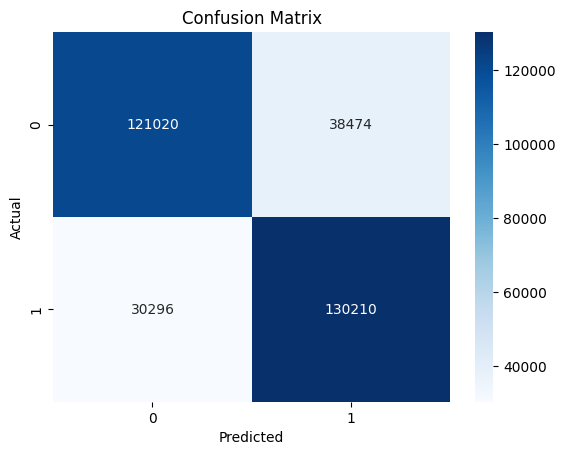

In [11]:
#Evaluate the model and make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print(classification_report(y_test, y_pred_binary))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()